In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import Imputer, LabelEncoder
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from scipy.special import boxcox1p
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, SGDRegressor
from sklearn.pipeline import make_pipeline
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.cross_validation import train_test_split, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score

# Import Training and Testing Data

In [39]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [40]:
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [41]:
print("\n Training Data Shape: ", data_train.shape)


 Training Data Shape:  (1460, 81)


In [42]:
data_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [43]:
print("\n Training Data Shape: ", data_test.shape)


 Training Data Shape:  (1459, 80)


# Drop ID column

In [44]:
id_train = data_train['Id']
data_train.drop("Id", axis=1, inplace=True)

id_test = data_test['Id']
data_test.drop("Id", axis=1, inplace=True)

# Analyzing Target Variable: SalePrice

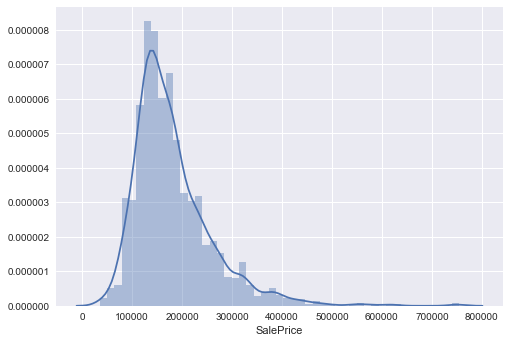

In [45]:
sns.distplot(data_train['SalePrice'])
sns.plt.show()

In [46]:
data_train['SalePrice'].describe()
(mu, sigma) = stats.norm.fit(data_train['SalePrice'])
print('mu = {:.2f} , sigma = {:.2f}'.format(mu,sigma))

mu = 180921.20 , sigma = 79415.29


# Logarithmic Transform

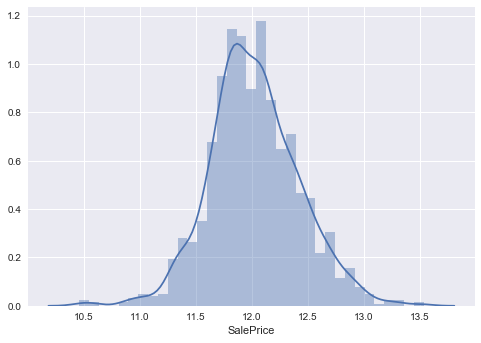

In [47]:
# Using log(1+x) to avoid log(0)
data_train['SalePrice'] = np.log1p(data_train['SalePrice'])
sns.distplot(data_train['SalePrice'])
sns.plt.show()

In [48]:
data_train['SalePrice'].describe()
(mu, sigma) = stats.norm.fit(data_train['SalePrice'])
print('mu = {:.2f} , sigma = {:.2f}'.format(mu,sigma))

mu = 12.02 , sigma = 0.40


# Combine Training and Testing Data

In [49]:
all_data = pd.concat((data_train,data_test))
all_data.shape

(2919, 80)

# Number of Missing Values

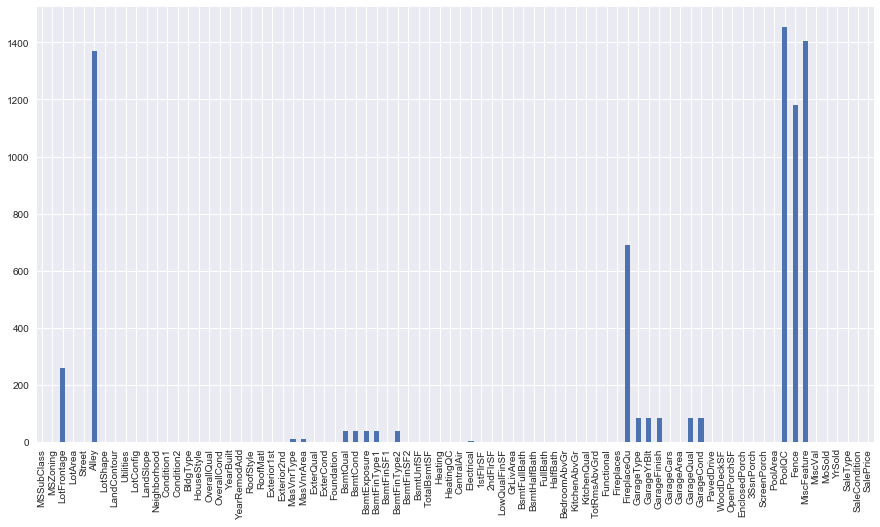

In [50]:
# Training Data
plt.figure(figsize=(15,8))
data_train.isnull().sum(axis=0).plot(kind='bar')
plt.show()

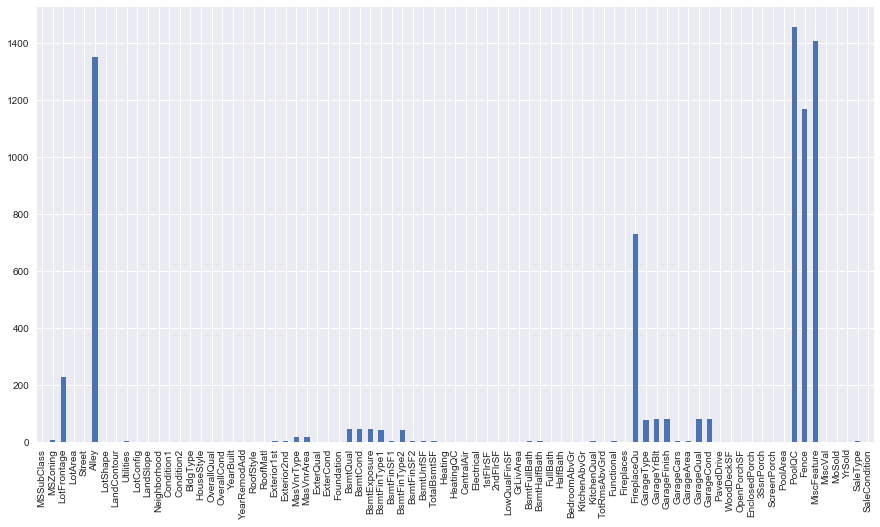

In [51]:
# Testing Data
plt.figure(figsize=(15,8))
data_test.isnull().sum(axis=0).plot(kind='bar')
plt.show()

# Impute missing values

In [52]:
#Training Data

data_train['LotFrontage'] = data_train['LotFrontage'].fillna(data_train['LotFrontage'].median())
data_train['Alley'] = data_train['Alley'].fillna('None')
data_train['MasVnrType'] = data_train['MasVnrType'].fillna('None')
data_train['MasVnrArea'] = data_train['MasVnrArea'].fillna(0)

for cols in ('BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'):
    data_train[cols] = data_train[cols].fillna('None')

data_train['Electrical'] = data_train['Electrical'].fillna(data_train['Electrical'].mode()[0])
data_train['FireplaceQu'] = data_train['FireplaceQu'].fillna('None')

for cols in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data_train[cols] = data_train[cols].fillna('None')
    
for cols in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data_train[cols] = data_train[cols].fillna(0)
    
data_train['PoolQC'] = data_train['PoolQC'].fillna('None')
data_train['Fence'] = data_train['Fence'].fillna('None')
data_train['MiscFeature'] = data_train['MiscFeature'].fillna('None')

data_train.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC      

In [53]:
# Testing Data

data_test['MSZoning'] = data_test['MSZoning'].fillna(data_test['MSZoning'].mode()[0])
data_test['LotFrontage'] = data_test['LotFrontage'].fillna(data_test['LotFrontage'].median())
data_test['Alley'] = data_test['Alley'].fillna('None')
data_test['Utilities'] = data_test['Utilities'].fillna(data_test['Utilities'].mode()[0])

data_test['MasVnrType'] = data_test['MasVnrType'].fillna('None')
data_test['MasVnrArea'] = data_test['MasVnrArea'].fillna(0)

for cols in ('BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'):
    data_test[cols] = data_test[cols].fillna('None')
    
for cols in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data_test[cols] = data_test[cols].fillna(0)

data_test['Electrical'] = data_test['Electrical'].fillna(data_test['Electrical'].mode()[0])
data_test['FireplaceQu'] = data_test['FireplaceQu'].fillna('None')

for cols in ('Exterior1st', 'Exterior2nd'):
    data_test[cols] = data_test[cols].fillna(data_test[cols].mode()[0])

for cols in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data_test[cols] = data_test[cols].fillna('None')
    
for cols in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data_test[cols] = data_test[cols].fillna(0)
    
data_test['KitchenQual'] = data_test['KitchenQual'].fillna(data_test['KitchenQual'].mode()[0])
data_test["Functional"] = data_test["Functional"].fillna("Typ")
    
data_test['PoolQC'] = data_test['PoolQC'].fillna('None')
data_test['Fence'] = data_test['Fence'].fillna('None')
data_test['MiscFeature'] = data_test['MiscFeature'].fillna('None')
data_test['SaleType'] = data_test['SaleType'].fillna(data_test['SaleType'].mode()[0])

data_test.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea    

# Feature Engineering

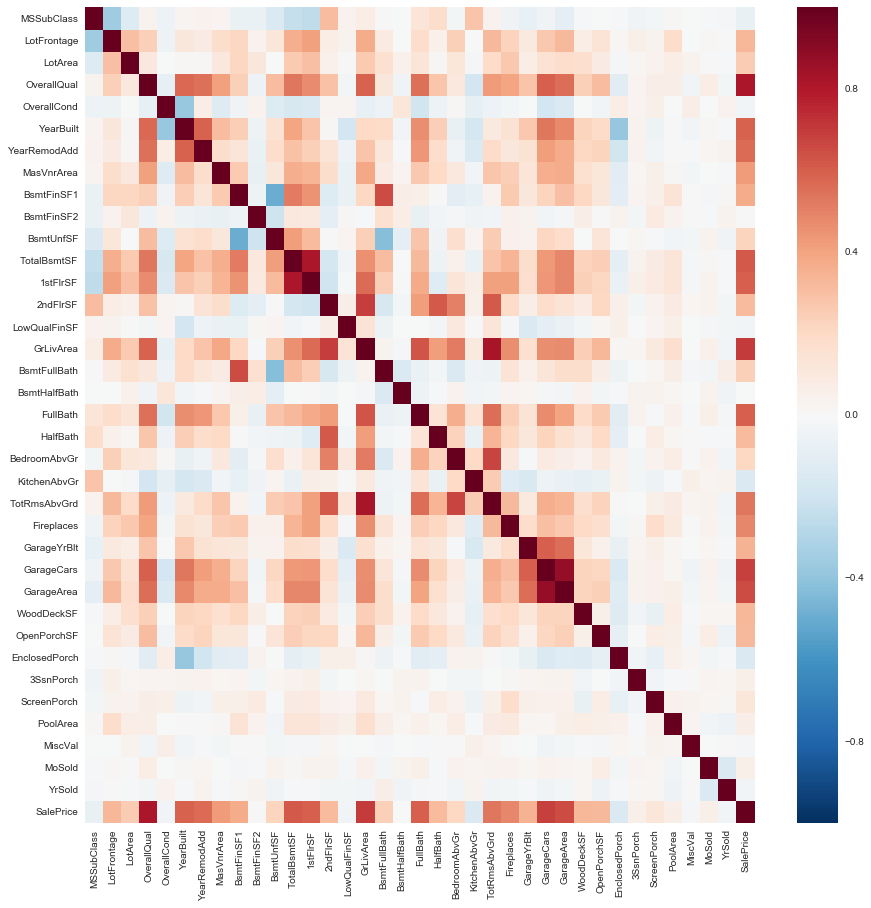

In [54]:
corr_mat = data_train.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr_mat)
sns.plt.show()

In [55]:
print(corr_mat['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.426776
BsmtFinSF1       0.372023
GarageYrBlt      0.349013
LotFrontage      0.335292
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePrice, dtype: float64


# Outlier Detection
## Data description mentions the outliers being only in GrLivArea Variable

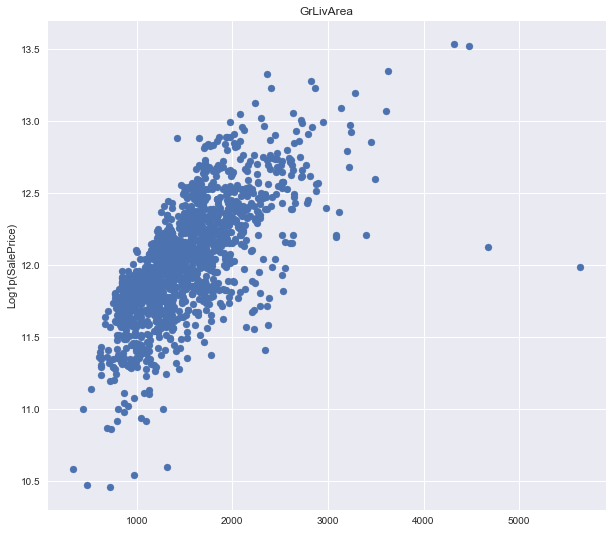

In [56]:
f, ax = plt.subplots(figsize=(10, 9))

ax.scatter(data_train['GrLivArea'], data_train['SalePrice'])
ax.set_title('GrLivArea')
plt.ylabel('Log1p(SalePrice)')

plt.show()

# Outlier Removal

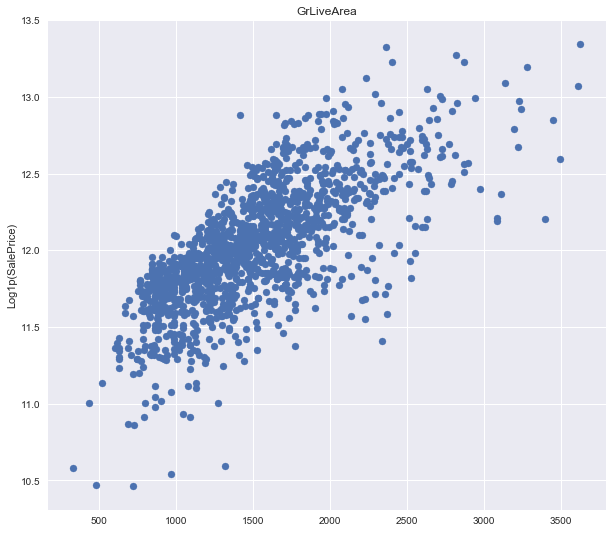

In [57]:
data_train = data_train.drop(data_train[(data_train['GrLivArea']>4000)].index)

f, ax = plt.subplots(figsize=(10, 9))
ax.scatter(data_train['GrLivArea'], data_train['SalePrice'])
ax.set_title('GrLiveArea')
plt.ylabel('Log1p(SalePrice)')
plt.show()

# Scatter plots for some of the most correlated variables with Target Variable

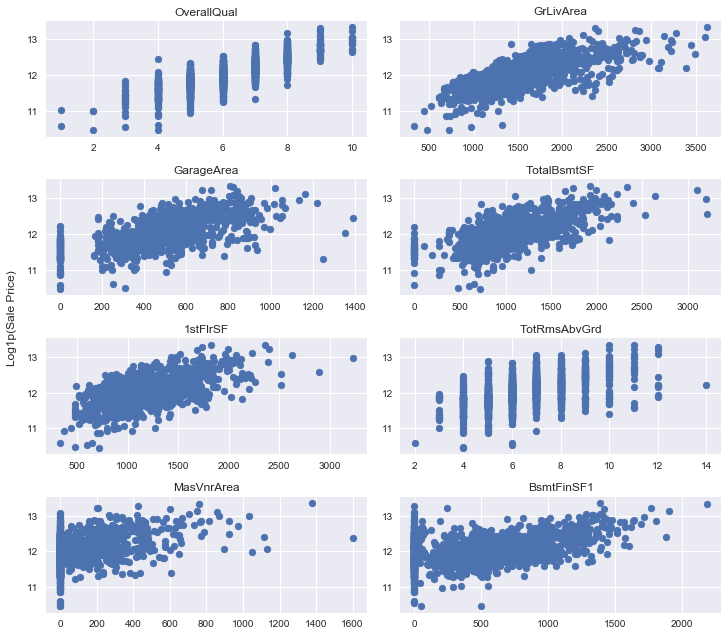

In [58]:
plt.figure(1)
f, ax = plt.subplots(4, 2, figsize=(10, 9))

price = data_train.SalePrice.values

ax[0, 0].scatter(data_train['OverallQual'].values, price)
ax[0, 0].set_title('OverallQual')

ax[0, 1].scatter(data_train['GrLivArea'].values, price)
ax[0, 1].set_title('GrLivArea')

ax[1, 0].scatter(data_train['GarageArea'].values, price)
ax[1, 0].set_title('GarageArea')

ax[1, 1].scatter(data_train['TotalBsmtSF'].values, price)
ax[1, 1].set_title('TotalBsmtSF')

ax[2, 0].scatter(data_train['1stFlrSF'].values, price)
ax[2, 0].set_title('1stFlrSF')

ax[2, 1].scatter(data_train['TotRmsAbvGrd'].values, price)
ax[2, 1].set_title('TotRmsAbvGrd')

ax[3, 0].scatter(data_train['MasVnrArea'].values, price)
ax[3, 0].set_title('MasVnrArea')

ax[3, 1].scatter(data_train['BsmtFinSF1'].values, price)
ax[3, 1].set_title('BsmtFinSF1')

f.text(-0.01, 0.5, 'Log1p(Sale Price)', va='center', rotation='vertical', fontsize = 12)

plt.tight_layout()
plt.show()

# Combine Training and Testing Data

In [59]:
y_train = data_train['SalePrice']

#Index for splitting combined data into train and split later
index_train = data_train.shape[0]
index_test = data_test.shape[0]

comb_data = pd.concat((data_train, data_test)).reset_index(drop=True)
comb_data.drop('SalePrice', axis=1, inplace=True)

print("Comb_data shape: {}".format(comb_data.shape))

Comb_data shape: (2915, 79)


# Convert certain numerical values to categorical type

In [60]:
comb_data['MoSold'] = comb_data['MoSold'].astype(str)
comb_data['OverallCond'] = comb_data['OverallCond'].astype(str)
comb_data['MSSubClass'] = comb_data['MSSubClass'].astype(str)

# Label Encoding

In [61]:
columns = ('BsmtQual','ExterCond','FireplaceQu','GarageQual', 'GarageCond', 'CentralAir','BldgType',
            'ExterQual','Street','HeatingQC','PoolQC','KitchenQual','BsmtCond','BsmtFinType1','SaleType', 
            'BsmtFinType2','BsmtExposure','Functional', 'Fence', 'GarageFinish', 'LandSlope','Utilities',
            'PavedDrive','Alley','MSSubClass','OverallCond','MoSold','LotShape')

for cols in columns:
    lbl_enc = LabelEncoder() 
    lbl_enc.fit(list(comb_data[cols].values)) 
    comb_data[cols] = lbl_enc.transform(list(comb_data[cols].values))
    
comb_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,0,4,3,706.0,0.0,...,8,0,1,8,856.0,0,0,2003,2003,2008
1,1262,0,0,1,3,0,4,1,978.0,0.0,...,8,0,1,6,1262.0,0,298,1976,1976,2007
2,920,866,0,1,3,0,4,2,486.0,0.0,...,8,0,1,6,920.0,0,0,2001,2002,2008
3,961,756,0,1,3,0,1,3,216.0,0.0,...,8,0,1,7,756.0,0,0,1915,1970,2006
4,1145,1053,0,1,4,0,4,0,655.0,0.0,...,8,0,1,9,1145.0,0,192,2000,2000,2008


# Check Skew of Variables

In [62]:
num_features = comb_data.dtypes[comb_data.dtypes!="object"].index

skew_features = comb_data[num_features].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
skew_amount = pd.DataFrame({'Skew Amount' :skew_features})
skew_amount

,Skew Amount
Utilities,53.962953
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
LandSlope,4.971350
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796


# Box-Cox Transformation of skewed features

In [63]:
high_skew = skew_amount[abs(skew_amount) > 1]
high_skew_features = high_skew.index
lam = 0.20 #Lambda 
for feature in high_skew_features:
    comb_data[feature] = boxcox1p(comb_data[feature], lam)

print("Number of features transformed: ", high_skew_features.shape[0])

Number of features transformed:  61


# Generating Dummy Categorical Features

In [64]:
comb_data = pd.get_dummies(comb_data)
print(comb_data.shape)

(2915, 208)


# Splitting Train and Test Data

In [65]:
x_train = comb_data[:index_train]
x_test = comb_data[index_train:]

# Regression Models

## 1. XGBRegressor

In [66]:
xgbr_clf = XGBRegressor()
parameters = {'n_estimators':[250,350,450], 'max_depth':[3,5,7], 'learning_rate':[0.1,0.01,0.001]}
xgbr_gridsearch = GridSearchCV(estimator=xgbr_clf, param_grid=parameters, cv=10)
xgbr_gridsearch.fit(x_train,y_train)
xgbr_predict = xgbr_gridsearch.predict(x_train)
print("Best Score: %0.3f" % xgbr_gridsearch.best_score_)
print("Best Parameters: ")
best_parameters=xgbr_gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best Score: 0.911
Best Parameters: 
	learning_rate: 0.1
	max_depth: 3
	n_estimators: 450


# 2. Lasso Regression

In [67]:
lasso = Lasso(fit_intercept=True, warm_start=True)
parameters = {'lasso__alpha':[0.0003,0.0005,0.001]}
lasso_model = make_pipeline(RobustScaler(), lasso)
lasso_gridsearch = GridSearchCV(estimator=lasso_model, param_grid=parameters, cv=10)
lasso_gridsearch.fit(x_train,y_train)
lasso_predict = lasso_gridsearch.predict(x_train)
print("Best Score: %0.3f" % lasso_gridsearch.best_score_)
print("Best Parameters: ")
best_parameters=lasso_gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best Score: 0.921
Best Parameters: 
	lasso__alpha: 0.0003


# Combining XGBRegressor and Lasso outputs in a DataFrame

In [68]:
reg_outputs = pd.DataFrame()
reg_outputs['XGBReg'] = xgbr_predict
reg_outputs['Lasso'] = lasso_predict

reg_outputs.shape

(1456, 2)

# Stacking using SGDRegressor

In [69]:
sgd_reg = SGDRegressor(loss='squared_loss', warm_start=True, max_iter=100)
parameters = {'penalty':['l2','l1'], 'alpha':[0.01,0.001,0.0001]}
loo = LeaveOneOut(len(y_train))
sgd_gridsearch = GridSearchCV(estimator=sgd_reg, param_grid=parameters, cv=loo)
sgd_gridsearch.fit(reg_outputs,y_train)
sgd_predict = sgd_gridsearch.predict(reg_outputs)
print("Best Parameters: ")
best_parameters=sgd_gridsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best Parameters: 
	alpha: 0.01
	penalty: 'l2'


# Combine All Results into one DataFrame

In [70]:
comb_results = pd.DataFrame()
comb_results['XGBReg'] = np.expm1(xgbr_predict)
comb_results['XGBReg'] = comb_results.XGBReg.round()
comb_results['Lasso'] = np.expm1(lasso_predict)
comb_results['Lasso'] = comb_results.Lasso.round()
comb_results['SGDReg'] = np.expm1(sgd_predict)
comb_results['SGDReg'] = comb_results.SGDReg.round()
comb_results['Actual'] = np.expm1(y_train)

comb_results.head()

,XGBReg,Lasso,SGDReg,Actual
0,210078.0,208738.0,207554.0,208500.0
1,178653.0,179791.0,177547.0,181500.0
2,210658.0,219235.0,211788.0,223500.0
3,146740.0,165660.0,152487.0,140000.0
4,281494.0,291689.0,281999.0,250000.0


# Test Data Prediction

In [71]:
xgbr_test = xgbr_gridsearch.predict(x_test)
lasso_test = lasso_gridsearch.predict(x_test)

test_outputs = pd.DataFrame()
test_outputs['XGBReg'] = xgbr_test
test_outputs['Lasso'] = lasso_test

final_pred = np.expm1(sgd_gridsearch.predict(test_outputs))

# Submission

In [37]:
submission = pd.DataFrame()
submission['Id'] = id_test
submission['SalePrice'] = final_pred
submission.to_csv('submission.csv',index=False)